# Loading the packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import dask.dataframe as dd
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

# Importing the data

In [4]:
df_jan_path = "../data/raw/yellow_tripdata_2016-01.csv"
df_feb_path = "../data/raw/yellow_tripdata_2016-02.csv"
df_mar_path = "../data/raw/yellow_tripdata_2016-03.csv"

usecols = ["trip_distance", "pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude", "fare_amount"]

df_jan = dd.read_csv(df_jan_path, assume_missing=True, usecols=usecols)
df_feb = dd.read_csv(df_feb_path, assume_missing=True, usecols=usecols)
df_mar = dd.read_csv(df_mar_path, assume_missing=True, usecols=usecols)

In [5]:
df = dd.concat([df_jan, df_feb, df_mar], axis=0)
df

,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount
npartitions=82,,,,,,
,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...
...,...,...,...,...,...,...
,...,...,...,...,...,...
,...,...,...,...,...,...


# Bounds

The latitude and longitude bounds of NYC are:
* Minimum latitude = 40.60
* Maximum latitude = 40.85
* Minimum longitude = -74.05
* Maximum longitude = -73.70

In [6]:
min_lat = 40.60
max_lat = 40.85
min_lon = -74.05
max_lon = -73.70

In [7]:
# `fare_amount` and `trip_distance` columns

fare_amount = df["fare_amount"].compute()
trip_distance = df["trip_distance"].compute()

Let us check the number of columns.

In [8]:
fare_amount.shape[0]

34499859

Let us check the percentile values for fare amount.

In [10]:
percentile_values = np.arange(0.991,1.000, 0.001)
fare_amount.quantile(percentile_values)

0.991        52.00
0.992        52.00
0.993        52.00
0.994        52.00
0.995        54.00
0.996        58.50
0.997        63.00
0.998        69.00
0.999        81.00
1.000    429496.72
Name: fare_amount, dtype: float64

I will choose the 99.9th percentile as the maximum value for `fare_amount`. I will consider anything lying above it as an outlier and drop it. Further, the NYC TLC states that the minimum fare is $0.5. So, I will set these as the bounds for `fare_amount`.

In [11]:
max_fare_amount = fare_amount.quantile(percentile_values).iloc[-2].item()
min_fare_amount = 0.5

print(f"The maximum `fare_amount` is ${max_fare_amount}, and the minimum `fare_amount` is ${min_fare_amount}.")

The maximum `fare_amount` is $81.0, and the minimum `fare_amount` is $0.5.


Let us do the same for `trip_distance`.

In [12]:
trip_distance.quantile(percentile_values)

0.991          18.80
0.992          19.00
0.993          19.30
0.994          19.63
0.995          20.04
0.996          20.51
0.997          21.10
0.998          21.90
0.999          24.43
1.000    19072628.80
Name: trip_distance, dtype: float64

I will again choose the 99.9th percentile as the maximum value for `trip_distance`. Again, the NYC TLC states that the minimum trip distance is 0.25 miles. So, I will set these bounds for `trip_distance`.

In [14]:
max_trip_distance = trip_distance.quantile(percentile_values).iloc[-2].item()
min_trip_distance = 0.25

print(f"The maximum `trip_distance` is {max_trip_distance} miles, and the minimum `trip_distance` is {min_trip_distance} miles.")

The maximum `trip_distance` is 24.43 miles, and the minimum `trip_distance` is 0.25 miles.


# Removing Outliers

In [15]:
df = df.loc[
    (df["pickup_latitude"].between(min_lat, max_lat, inclusive="both")) & 
    (df["pickup_longitude"].between(min_lon, max_lon, inclusive="both")) & 
    (df["dropoff_latitude"].between(min_lat, max_lat, inclusive="both")) & 
    (df["dropoff_longitude"].between(min_lon, max_lon, inclusive="both")),
    :
]
df = df.loc[
    (df["fare_amount"].between(min_fare_amount, max_fare_amount, inclusive="both")) & 
    (df["trip_distance"].between(min_trip_distance, max_trip_distance, inclusive="both")),
    :
]

## Location subset

In [16]:
location_subset = df[["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"]]
location_subset

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
npartitions=82,,,,
,float64,float64,float64,float64
,...,...,...,...
...,...,...,...,...
,...,...,...,...
,...,...,...,...


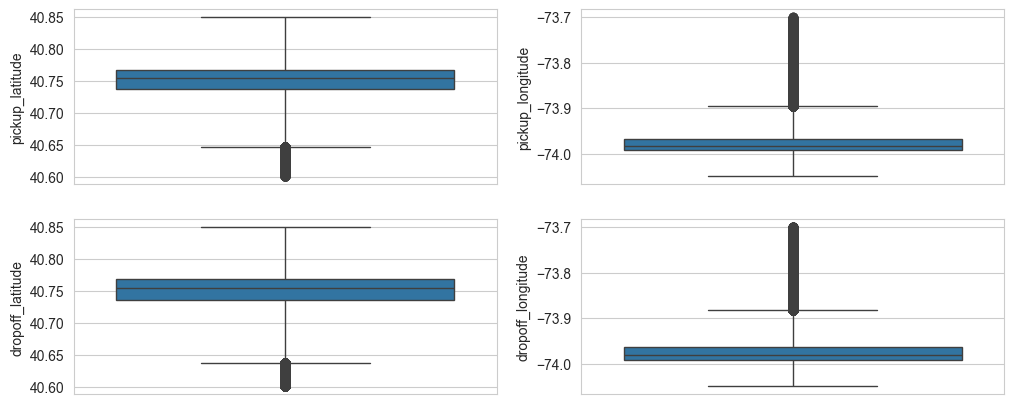

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=2, figsize=(12,5))
for i in range(4):
    if i <= 1:  # pickup
        sns.boxplot(y=location_subset.iloc[:, i].compute(), ax=ax1[i], whis=3)
    else:  # dropoff
        sns.boxplot(y=location_subset.iloc[:, i].compute(), ax=ax2[i - 2], whis=3)

The box plots look a lot more acceptable right now. They do have some extreme values, but they aren't really outliers.

## `trip_distance`

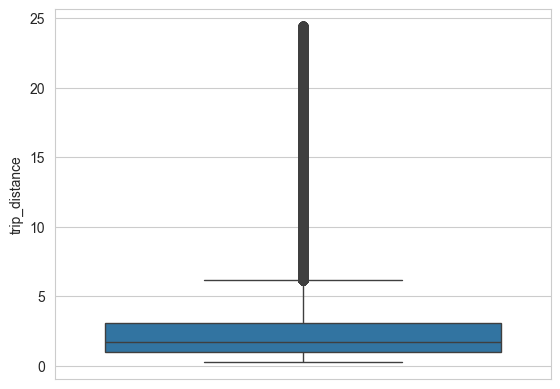

In [18]:
sns.boxplot(df["trip_distance"].compute());

Again, the boxplot looks a lot more acceptable.

## `fare_amount`

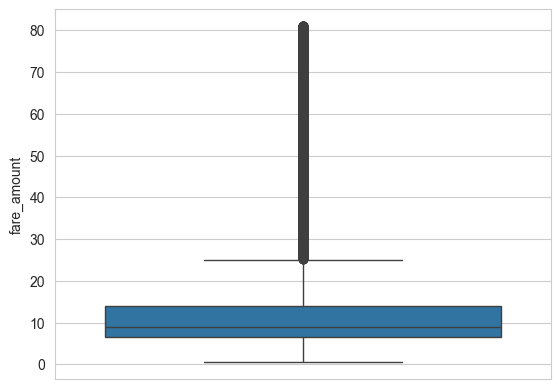

In [19]:
sns.boxplot(df["fare_amount"].compute());

Again, the boxplot looks a lot more acceptable.

# Saving the data with pickup coordinates

In [20]:
INTERIM_DATA_PATH = "../data/interim/pickup_coord_data.csv"

pickup_coord_data = df[["pickup_latitude", "pickup_longitude"]]

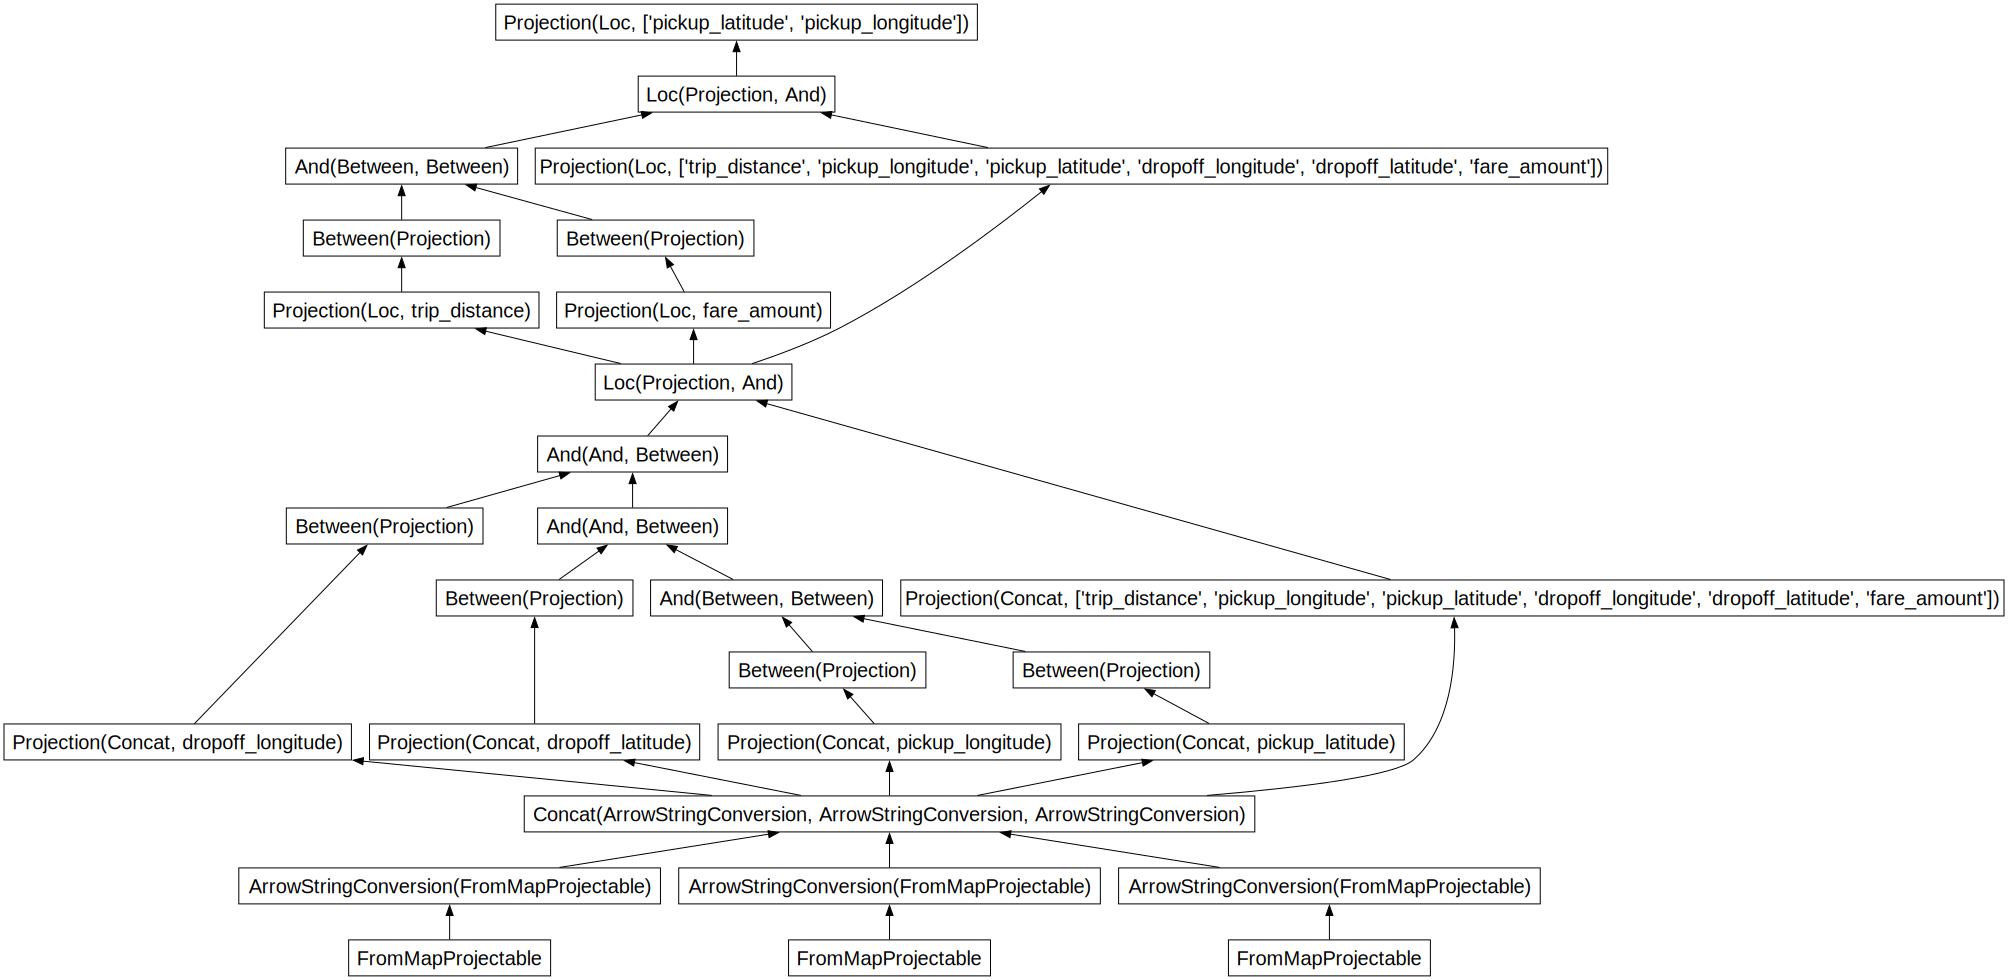

In [21]:
pickup_coord_data.visualize(tasks=False, filename=None)

In [22]:
pickup_coord_data = df[["pickup_latitude", "pickup_longitude"]].compute()

In [23]:
print(f"Shape of the pickup coordinates data is {pickup_coord_data.shape}.")

Shape of the pickup coordinates data is (33234199, 2).


In [24]:
pickup_coord_data

,pickup_latitude,pickup_longitude
0,40.734695,-73.990372
1,40.729912,-73.980782
2,40.679565,-73.984550
3,40.718990,-73.993469
4,40.781330,-73.960625
...,...,...
420269,40.644451,-73.790565
420270,40.641483,-73.788055
420271,40.646736,-73.789154
420273,40.774471,-73.977356


In [25]:
# pickup_coord_data.to_csv(INTERIM_DATA_PATH, index=False)